# Проектный практикум 3. Учебная задача


Краткое описание:

Создать нейронную сеть, способную генерировать текстовые отзывы о различных местах на основе определенных входных параметров, таких как категория места, средний рейтинг и ключевые слова.

Данные: https://github.com/yandex/geo-reviews-dataset-2023

Описание датасета

500 000 уникальных отзывов
Только отзывы на организации в России
Доступны на Яндекс Картах
Опубликованы с января по июль 2023 года
Датасет не содержит коротких односложных отзывов
Тексты очищены от персональных данных (номеров телефонов, адресов почты)
Состав датасета

Датасет в формате tskv содержит следующую информацию:

Адрес организации (address)
Название организации (name_ru)
Список рубрик, к которым относится организация (rubrics)
Оценка пользователя от 0 до 5 (rating)
Текст отзыва (text)

Так как лимит на скачивание lfs из репозитория на гитхаб был закрыт, то мы взяли тот же датасет с kaggle

In [2]:
!pip install wget datasets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=a596eee03d64fa71cc61f98ec7c7603d8fca7301376adb525c15316e6c605646
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

In [3]:
import wget

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import torch

import string
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
import os
import shutil
from datasets import Dataset, load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    GPT2LMHeadModel,
    GPT2TokenizerFast,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from random import randint

%matplotlib inline

In [9]:
!pip install kaggle

In [10]:
from google.colab import files

files.upload()  # Загрузите kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iliaberlov","key":"79380341e9bf51a0230ff1da9c1060fd"}'}

In [11]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [12]:
!kaggle datasets download -d kyakovlev/yandex-geo-reviews-dataset-2023 --unzip

Dataset URL: https://www.kaggle.com/datasets/kyakovlev/yandex-geo-reviews-dataset-2023
License(s): other
 95% 189M/200M [00:01<00:00, 150MB/s]
100% 200M/200M [00:01<00:00, 144MB/s]


Предобработка и анализ данных

In [4]:
df = pd.read_csv('geo-reviews-dataset-2023.tskv', sep='\t', header=None, names=['address', 'name_ru', 'rating', 'rubrics', 'text'])
columns = df.columns.to_list()
# Пройдем в цикле по колонкам и удалим из ячеек ключи
for column in columns:
    df[column] = df[column].replace(f'{column}=', '', regex=True)

In [5]:
# Посмотрим первые строки
df.head()

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


In [31]:
# Размер датафрейма
print(f'Размер датафрейма: {df.shape}')

Размер датафрейма: (500000, 5)


In [32]:
# Типы данных
print(df.dtypes)

address    object
name_ru    object
rating     object
rubrics    object
text       object
dtype: object


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  500000 non-null  object
 1   name_ru  500000 non-null  object
 2   rating   500000 non-null  object
 3   rubrics  500000 non-null  object
 4   text     499030 non-null  object
dtypes: object(5)
memory usage: 19.1+ MB


Проверим на количество дубликатов и отсутствующих значений

In [5]:
df = df.dropna(ignore_index=True)
# Проверим наличие дубликатов
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
num_duplicates

1

In [6]:
# Теперь обрежем точку после цифры в колонке 'rating' и приведем колонку к типу int64
df['rating'] = df['rating'].replace('\.', '', regex=True)
df['rating'] = pd.to_numeric(df['rating'])

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499030 entries, 0 to 499029
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   address  499030 non-null  object
 1   name_ru  499030 non-null  object
 2   rating   499030 non-null  int64 
 3   rubrics  499030 non-null  object
 4   text     499030 non-null  object
dtypes: int64(1), object(4)
memory usage: 19.0+ MB


In [7]:
df.head()

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


<Axes: xlabel='rating', ylabel='Count'>

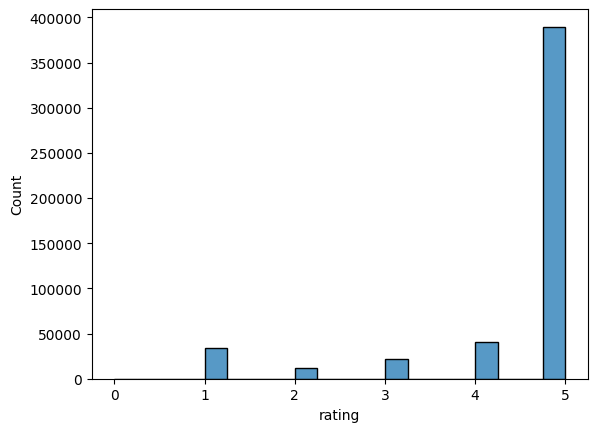

In [38]:
sns.histplot(df['rating'])

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
df.to_csv('/content/drive/My Drive/full_dataframe.tskv', sep='\t', index=False, header=True, encoding='utf-8')


Построив распределние по рейтингам мы видим что самым частым является оценка в 5 баллов

In [39]:
df.query('rating == 0').head()

,address,name_ru,rating,rubrics,text
1906,"Республика Карелия, Суоярви, улица Шельшакова, 1",Гостиница Карелия,0,Гостиница,"Гостиница расположенна удобно, если отремонтир..."
2164,"Кемерово, улица Тухачевского, 12",Светофор,0,Магазин автозапчастей и автотоваров;Автоаксесс...,Это мой любимый магазин с запчастями. Можно вс...
3583,"Краснодарский край, Анапа, улица Пушкина, 30",Кубань,0,Санаторий,"Нет растительного масла для салата, нет зубочи..."
3614,"Краснодарский край, Туапсинский район, Новомих...",Счастливый Хотей,0,Гостиница,"Все довольны, и взрослые и дети.\nВкусная еда...."
6384,"Ленинградская область, Выборг, улица Мира, 8А",Атриум,0,Торговый центр,"Большой выбор, очень грамотно и удобно разложе..."


In [8]:
df['review_length'] = df['text'].str.len()
df['review_length'].describe()

,review_length
count,499030.000000
mean,303.232533
std,292.609661
min,2.000000
25%,145.000000
50%,215.000000
75%,365.000000
max,20162.000000


<Axes: xlabel='review_length', ylabel='Count'>

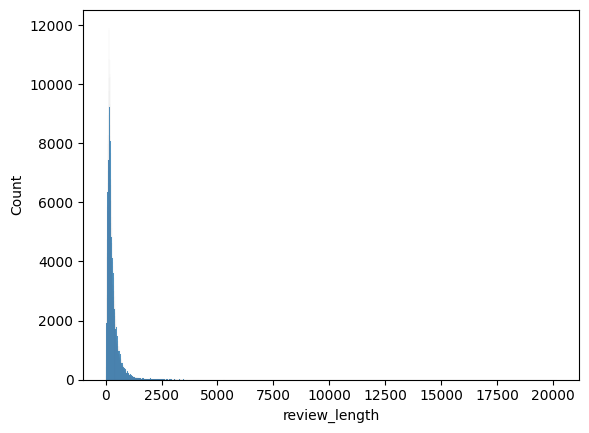

In [41]:
sns.histplot(df['review_length'])

Как видно есть выбросы с очень короткой длиной комментария
> Добавить блок с цитатой



In [42]:
df.query('review_length < 10')['text'].values

array(['Круто', 'Круто', 'кайф\\n', 'Все круто', 'Отлично ', 'Отлично!',
       'Прилично ', 'Лучшие!', 'Клас!', 'Класс', 'Хорошо ', 'Удобно',
       'Супер', 'Не плохо ', 'Нормально', 'Спасибо!', 'Отлично',
       'Спасибо', 'Норм', 'Стандарт.', 'Чисто!', 'Все отл', 'Удобно',
       'Хорошо', '10 из 10', 'Ок', 'Вкусно', 'Супер', 'Норм', 'Вкусно',
       'Красавцы', 'Не вкусно', 'Все норм.', 'Профи!', 'Отлично.',
       'Круть', 'Чисто', 'Отлично.', 'Хорошо ', 'Бомба', 'Всё супер',
       'топ топ', 'Норм', 'Вполне!', 'Всё чëтко', 'Вкусно', 'Класс! '],
      dtype=object)

Токенизируем текст отзывов и выбираем ключевые самые частые слова

In [12]:
# Соберем все тексты отзывов в одну строку
words_list_list = df['text'].to_list()
words_str = ' '.join(str(string) for string in words_list_list)

In [13]:
import string
import re

# Файл для сохранения обработанного текста
output_file = "/content/drive/My Drive/processed_reviews.txt"

# Функция для очистки текста
def clean_text(text):
    spec_chars = string.punctuation + '\n\xa0«»\t—…n'
    text = re.sub(f"[{re.escape(spec_chars)}]", "", text)  # Удаляем спецсимволы
    text = re.sub(r"\d+", "", text)  # Удаляем цифры
    return text.lower()

# Открываем файл на запись
with open(output_file, "w", encoding="utf-8") as f_out:
    for text in df['text']:
        if pd.notna(text):  # Пропускаем NaN
            clean_line = clean_text(str(text))  # Очищаем строку
            f_out.write(clean_line + "\n")  # Записываем в файл

print(f"Обработанный текст сохранен в: {output_file}")


Обработанный текст сохранен в: /content/drive/My Drive/processed_reviews.txt


In [17]:
import nltk
from nltk.tokenize import word_tokenize

# Скачиваем необходимые ресурсы для токенизации
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [18]:
# Токенизируем текст
# Прочитаем текст из файла
input_file = "/content/drive/My Drive/processed_reviews.txt"

with open(input_file, "r", encoding="utf-8") as f:
    text = f.read()  # Считываем весь текст

# Токенизируем текст
text_tokens = word_tokenize(text)

# Проверим первые 10 токенов
print(text_tokens[:10])

['московский', 'квартал', 'шумно', 'летом', 'по', 'ночам', 'дикие', 'гонки', 'грязно', 'кругом']


In [19]:
# Путь для сохранения токенов на Google Drive
output_file = "/content/drive/My Drive/tokenized_reviews.txt"

# Записываем токены в файл (по одному на строку)
with open(output_file, "w", encoding="utf-8") as f_out:
    for token in text_tokens:
        f_out.write(token + "\n")  # Записываем каждый токен в новой строке

print(f"Токенизированный текст сохранен в: {output_file}")


Токенизированный текст сохранен в: /content/drive/My Drive/tokenized_reviews.txt


In [20]:
# Посмотрим статистику по неочищенным словам
# Для применения инструментов частотного анализа библиотеки NLTK необходимо список токенов преобразовать к классу Text
text = nltk.Text(text_tokens)
fdist = FreqDist(text)

In [21]:
# Теперь очистим слова от служебных частей речи
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")
custom_stopwords = ['очень', 'это', 'всё', 'всем', 'еще', 'ещё']
stopwords_united = russian_stopwords + custom_stopwords
text_with_no_stopwords = [word for word in text if word not in stopwords_united]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
# И посмотрим статистику по очищенным словам

fdist = FreqDist(text_with_no_stopwords)

print('Статистика по очищенным словам\n')
print(f'Всего слов: {fdist.N()}\n')
print(f'Уникальных слов: {fdist.B()}\n')
print('Топ-10 слов по частоте: ')
most_common_words = fdist.most_common(10)
for word in most_common_words:
    print(f'{word[0]}:  {word[1]}')

Статистика по очищенным словам

Всего слов: 14173971

Уникальных слов: 742776

Топ-10 слов по частоте: 
персонал:  82456
место:  74975
спасибо:  73776
рекомендую:  60037
просто:  49583
магазин:  46361
хороший:  43166
цены:  42268
вкусно:  40279
быстро:  40030


Word cloud

In [23]:
wordcloud = WordCloud(width=1200, height=600).generate_from_frequencies(fdist)

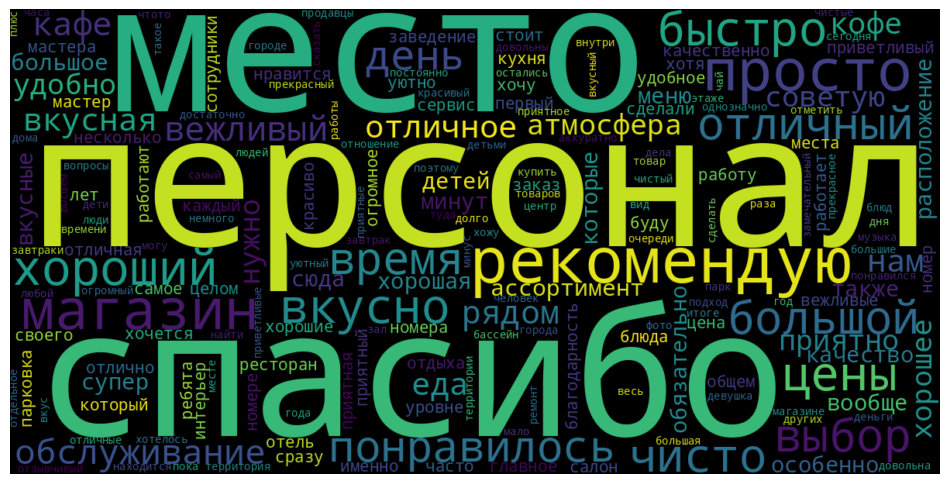

In [24]:
# Отображаем облако слов
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
Нормализация текстов (удаление спецсимволов, приведение к нижнему регистру)

In [25]:
def normalize_text(text):
    # Приведение к нижнему регистру
    text = text.lower()

    # Удаление специальных символов
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9\s]', '', text)

    return text

# Применяем функцию ко всем отзывам
df['text'] = df['text'].apply(normalize_text)

In [26]:
# Посмотрим сколько уникальных значений по столбцам
df.nunique()

,0
address,191639
name_ru,148456
rating,6
rubrics,31724
text,498805


In [27]:
# Убираем строки с рейтингом 0
df = df.query("rating > 0")

# Выводим кол-во уникальных значений по колонкам для проверки результата
df.nunique()

,0
address,191595
name_ru,148421
rating,5
rubrics,31715
text,498606


Очищаем датасет от выбросов - удаляем строки со слишком большой и слишком маленькой длиной текста отзыва

In [29]:
df['review_length'] = df['text'].str.len()

In [30]:
# Удаление отзывов с длиной более 3000 слов
df = df.query('review_length < 3000')

# Удаление отзывов с длиной менее 10 слов
df = df.query('review_length > 10')

In [31]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 498410 entries, 0 to 499029
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498410 non-null  object
 1   name_ru        498410 non-null  object
 2   rating         498410 non-null  int64 
 3   rubrics        498410 non-null  object
 4   text           498410 non-null  object
 5   review_length  498410 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 26.6+ MB


<Axes: xlabel='review_length', ylabel='Count'>

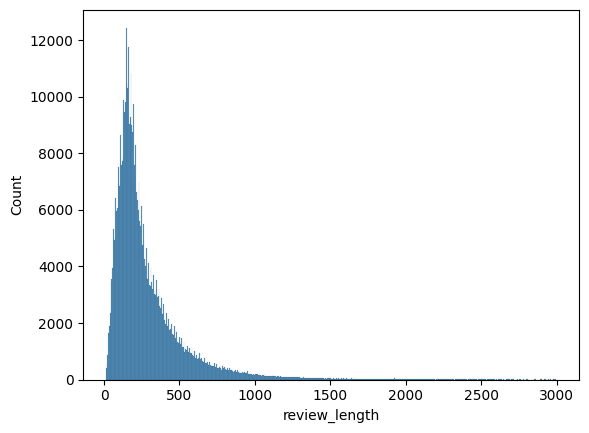

In [32]:
# Выведем график распределения по длине отзывов, для визуализации результата
sns.histplot(df['review_length'])

Заменяем символы переноса строки (\n) на пробелы:

In [33]:
df['text'] = df['text'].str.replace('\\n', ' ')

# И еще заменим откуда-то взявшиеся вместо пробелов буквы "n"
df['text'] = df['text'].str.replace('n', ' ')

In [34]:
# Сохраняем предобработанный датасет в tsv файл
df.to_csv('/content/drive/My Drive/dataset_preprocessed.tsv', sep='\t', index=False)


Для целей экономии времени мы обрезаем датасет вполовину до 20000 строк

In [35]:
file_path = '/content/drive/My Drive/dataset_preprocessed.tsv'  # Убедись, что путь правильный

# Читаем данные из файла
df = pd.read_csv(file_path, sep='\t')

# Проверяем информацию о DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498410 entries, 0 to 498409
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        498410 non-null  object
 1   name_ru        498410 non-null  object
 2   rating         498410 non-null  int64 
 3   rubrics        498410 non-null  object
 4   text           498410 non-null  object
 5   review_length  498410 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 22.8+ MB


In [36]:
# Создадим список, в который отправим категории, которые встречаются в датасете не менее 200 раз
frequent_rubrics = df.rubrics.value_counts().reset_index(name="count").query("count >= 200")['rubrics'].to_list()

# Заполним редкие рубрики NaN (если их нет в списке частх рубрик)
df['rubrics'] = df['rubrics'].apply(lambda rubric: rubric if rubric in frequent_rubrics else np.nan)

# Удалим NaN
df = df.dropna(ignore_index=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318962 entries, 0 to 318961
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   address        318962 non-null  object
 1   name_ru        318962 non-null  object
 2   rating         318962 non-null  int64 
 3   rubrics        318962 non-null  object
 4   text           318962 non-null  object
 5   review_length  318962 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 14.6+ MB


Мы берем по 4000 строк отзывов с каждым рейтингом

In [38]:
def balance_rating(df, len_for_each_rating=4000):
    # Создаем пустой DataFrame для результата
    df_cropped = pd.DataFrame()

    # Проходим по группам, которые образуются по уникальному рейтингу
    for rating, group in df.groupby('rating'):
        # Обрезаем группу по количеству строк, ограниченному len_for_each_rating
        cropped_group = group.head(len_for_each_rating)

        # Добавляем эту группу в итоговый DataFrame
        df_cropped = pd.concat([df_cropped, cropped_group], ignore_index=True)

    return df_cropped

# Применяем функцию
df_balanced = balance_rating(df, len_for_each_rating=4000)

# Проверим результат
df_balanced.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   address        20000 non-null  object
 1   name_ru        20000 non-null  object
 2   rating         20000 non-null  int64 
 3   rubrics        20000 non-null  object
 4   text           20000 non-null  object
 5   review_length  20000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 937.6+ KB


In [40]:
df_balanced.head()

,address,name_ru,rating,rubrics,text,review_length
0,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1,Фитнес-клуб,не знаю смутят ли когото данные правила но я б...,458
1,"Ставропольский край, Невинномысск, улица Павло...",Эште Дёнер,1,Кафе;Быстрое питание;Доставка еды и обедов,1 доставка очень долгая на рекламной брошюре н...,274
2,"Московская область, Наро-Фоминск, улица Калини...",Автомойка Чистякоff,1,Автомойка,раньше было нормально и мыли хорошо но больше ...,232
3,"Екатеринбург, ул. Хрустальногорская",Nova park,1,Жилой комплекс,когда выбирали квартиру атом был в приоритете ...,809
4,"Московская область, Жуковский, улица Баженова, 2А",Made in Vietnam,1,Быстрое питание,заказали фобо и томям короче больше не приду к...,360


<Axes: xlabel='rating', ylabel='Count'>

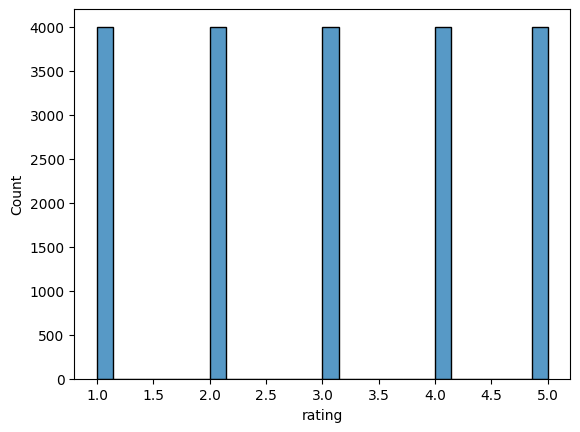

In [42]:
sns.histplot(df_balanced['rating'])

In [43]:
output_file = '/content/drive/My Drive/dataset_balanced.tsv'  # Путь к файлу на Google Drive

# Сохраняем обрезанный DataFrame в файл
df_balanced.to_csv(output_file, sep='\t', index=False)

print(f"Файл сохранен по пути: {output_file}")

Файл сохранен по пути: /content/drive/My Drive/dataset_balanced.tsv


In [5]:
import pandas as pd

# Путь к файлу на Google Drive
input_file = '/content/drive/My Drive/dataset_balanced.tsv'

# Читаем TSV файл
df = pd.read_csv(input_file, sep='\t')

# Проверяем информацию о данных
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   address        20000 non-null  object
 1   name_ru        20000 non-null  object
 2   rating         20000 non-null  int64 
 3   rubrics        20000 non-null  object
 4   text           20000 non-null  object
 5   review_length  20000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 937.6+ KB


Когда мы обучаем модель, особенно на задачах, связанных с генерацией текста или классификацией, очень важно, чтобы данные имели понятную структуру. Если данные представлены в свободном формате (например, просто текст), модель будет "случайным образом" пытаться понять, какие части текста связаны с чем. Это может быть сложнее для обучения, чем когда данные имеют четкую организацию.

Формат, в котором каждый отзыв начинается с категории (например, "Restaurant") и рейтинга (например, "Rating: 5"), помогает модели понять, какой контекст она должна генерировать или классифицировать.

Например:

"Category: Restaurants. Rating: 5. Review: ..."

Этот формат делает очевидным, что для ресторана с рейтингом 5 должен быть соответствующий отзыв, и модель легко будет искать эти паттерны, что повысит качество предсказаний.

In [6]:
def structure_review_data(row):
    return f"Category - {row['rubrics']}: Rating is {row['rating']}. Review Content: {row['text']}"

# Применяем функцию и создаем новый столбец с отформатированными отзывами
df['formatted_review'] = df.apply(structure_review_data, axis=1)

# Проверяем результат
df[['rubrics', 'rating', 'text', 'formatted_review']].head()


,rubrics,rating,text,formatted_review
0,Фитнес-клуб,1,не знаю смутят ли когото данные правила но я б...,Category - Фитнес-клуб: Rating is 1. Review Co...
1,Кафе;Быстрое питание;Доставка еды и обедов,1,1 доставка очень долгая на рекламной брошюре н...,Category - Кафе;Быстрое питание;Доставка еды и...
2,Автомойка,1,раньше было нормально и мыли хорошо но больше ...,Category - Автомойка: Rating is 1. Review Cont...
3,Жилой комплекс,1,когда выбирали квартиру атом был в приоритете ...,Category - Жилой комплекс: Rating is 1. Review...
4,Быстрое питание,1,заказали фобо и томям короче больше не приду к...,Category - Быстрое питание: Rating is 1. Revie...


Токенизация: Очень важный шаг перед подачей данных в модель, так как модели не работают с необработанным текстом, а только с числами (токенами).
Батчирование: Обработка данных батчами ускоряет процесс, так как модель обрабатывает несколько примеров за один раз. Это особенно важно при работе с большими датасетами.

In [7]:
tokenizer = GPT2TokenizerFast.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")

tokenizer.pad_token = tokenizer.eos_token

# Токенизация данных
def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=512)

# Пример применения
df['tokenized'] = df['formatted_review'].apply(tokenize_function)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

Здесь мы рассматриваем два подхода к токенизации Если у  небольшой датасет (например, несколько тысяч строк), можно использовать .apply(), так как он проще в реализации и не требует дополнительных библиотек.
Если с большим датасетом (сотни тысяч или миллионы строк), то стоит использовать Dataset.map(), чтобы ускорить процесс токенизации и уменьшить использование памяти

In [8]:
dataset = Dataset.from_pandas(df[['formatted_review']])

# Токенизация всех текстов
def tokenize_data(batch):
    return tokenizer(batch['formatted_review'], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [9]:
# Разделение на train/test
train_test_split = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

Collator — это функция или класс, который занимается подготовкой и объединением (батчингом) данных перед их подачей в модель. Это необходимая часть при обучении моделей, так как она отвечает за то, как данные будут подаваться в модель во время тренировки.

Когда обучаешь модель на тексте, данные часто представляют собой последовательности (например, предложения или абзацы), которые нужно преобразовать в батчи, чтобы эффективно обучать модель. Collator объединяет эти данные, может делать некоторые преобразования, такие как добавление паддинга или маскировка слов, и передает данные в модель.

In [10]:
# Создание collator для задачи языкового моделирования
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # GPT-2 не использует маскирование
)

In [11]:
train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)
output_train_file = '/content/drive/My Drive/train_dataset.csv'
output_test_file = '/content/drive/My Drive/test_dataset.csv'

# Сохраняем train и test в CSV
train_df.to_csv(output_train_file, index=False)
test_df.to_csv(output_test_file, index=False)

print(f"Train dataset сохранен по пути: {output_train_file}")
print(f"Test dataset сохранен по пути: {output_test_file}")


Train dataset сохранен по пути: /content/drive/My Drive/train_dataset.csv
Test dataset сохранен по пути: /content/drive/My Drive/test_dataset.csv


**ОБУЧЕНИЕ МОДЕЛИ**

Мы обучили модель на основе ai-forever/rugpt3small_based_on_gpt2, которая является легковесной предобученной моделью на русском языке, основанной на архитектуре GPT-2. Эта модель была обучена на больших объемах текстовых данных на русском языке и предназначена для задач генерации текста и других приложений языкового моделирования.

Основные особенности этой модели:

Легковесность: Модель оптимизирована для быстрого выполнения, что позволяет использовать ее на менее мощных вычислительных ресурсах по сравнению с более крупными моделями GPT-3.
Предобучение на русскоязычных данных: Модель прошла обучение на текстах на русском языке, что позволяет ей эффективно работать с русскоязычным контекстом, понимая грамматику, стиль и особенности языка.
Основана на GPT-2: Модель использует архитектуру GPT-2, которая является мощным инструментом для генерации последовательностей текста с учетом предыдущего контекста.

In [11]:

from transformers import AutoTokenizer, AutoModelForCausalLM

In [12]:
# Загрузка модели
model = AutoModelForCausalLM.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

In [13]:

from transformers import AutoTokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling

In [14]:
# Настройки обучения
training_args = TrainingArguments(
    fp16=True,  # Включение смешанной точности
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5, #увеличина скорость обучения, было 5e-5
    per_device_train_batch_size=6, #выше не дает, ругается на ограничения
    num_train_epochs=0.5,
    save_steps=10_000,
    save_total_limit=2,
    report_to="none",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
!pip install wandb

In [13]:
!pip install --upgrade transformers


In [15]:
from transformers import Trainer
import torch

# Проверяем, доступен ли GPU (CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Trainer
trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)


<ipython-input-15-4cf484f6f4d3>:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
# Обучение модели
trainer.train()

Epoch,Training Loss,Validation Loss
0,3.669100,3.600940


TrainOutput(global_step=1500, training_loss=3.8051502278645835, metrics={'train_runtime': 536.777, 'train_samples_per_second': 16.767, 'train_steps_per_second': 2.794, 'total_flos': 2351628288000000.0, 'train_loss': 3.8051502278645835, 'epoch': 0.5})

In [17]:
# Сохранение модели
output_dir = "./saved_model"

trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.json',
 './saved_model/merges.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [19]:
# Входные параметры
rubrics = "Быстрое питание"
rating = 5

In [20]:

# Формирование входного текста
input_text = f"rubrics = {rubrics}\nrating = {rating}\n"

In [21]:

# Токенизация текста
inputs = tokenizer(input_text, return_tensors="pt").to(device)

In [22]:
output = model.generate(
    **inputs,
    max_length=40,
    temperature=1.9,
    do_sample=True,
    num_return_sequences=3,
    eos_token_id=tokenizer.eos_token_id,  # Установка токена конца последовательности
    pad_token_id=tokenizer.eos_token_id,  # Использовать тот же токен для паддинга
    early_stopping=True,  # Раннее завершение на токене конца
    top_k=30,         # Уменьшаем количество рассматриваемых верхних k слов
    top_p=0.8,        # Уменьшаем "ядерность" распределения
)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


In [23]:

# Декодирование всех сгенерированных текстов
for i, sequence in enumerate(output):
    generated_text = tokenizer.decode(sequence, skip_special_tokens=True)
    print(f"Generated text {i + 1}:")
    print(generated_text)
    print()

Generated text 1:
rubrics = Быстрое питание
rating = 5
Кафе и рестораны поблизости;Ресторан: Rating is 3. Review Content: не знаю что лучше но на самом деле

Generated text 2:
rubrics = Быстрое питание
rating = 5
puppet2pupper: вкусная выпечка и много мяса очень вкусно и просто быстро нареканий нет есть минусы не

Generated text 3:
rubrics = Быстрое питание
rating = 5
Супер выбор продукции на сайте
Пицца;Пиццу соусы;Пекинская пицца: Rating is 1

